## Load Dataset

In [1]:
import os
import pandas as pd
from scipy.stats import zscore
import matplotlib as matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

from scipy.stats import rankdata
from IPython.display import display

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor




import itertools

In [2]:
df = pd.read_csv("data\Occupancy.csv")
df.head().T

,0,1,2,3,4
date,2015-02-02 14:19:00,2015-02-02 14:19:59,2015-02-02 14:21:00,2015-02-02 14:22:00,2015-02-02 14:23:00
Temperature,23.7,23.718,23.73,23.7225,23.754
Humidity,26.272,26.29,26.23,26.125,26.2
Light,585.2,578.4,572.666667,493.75,488.6
CO2,749.2,760.4,769.666667,774.75,779.0
HumidityRatio,0.004764,0.004773,0.004765,0.004744,0.004767
Occupancy,1,1,1,1,1


# Check columns and types in dataset

In [3]:
df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20560 entries, 0 to 20559
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           20560 non-null  object 
 1   Temperature    20560 non-null  float64
 2   Humidity       20560 non-null  float64
 3   Light          20560 non-null  float64
 4   CO2            20560 non-null  float64
 5   HumidityRatio  20560 non-null  float64
 6   Occupancy      20560 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.1+ MB


In [4]:
df.shape

(20560, 7)

# Cleaning the dataset

### Check for missing values

In [5]:
df.isnull().sum()

date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

### Check for duplicates

In [6]:
df['date'].duplicated().sum() 

np.int64(0)

# Look at basic statistics

In [7]:
df.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000
mean,20.906212,27.655925,130.756622,690.553276,0.004228,0.231031
std,1.055315,4.982154,210.430875,311.201281,0.000768,0.421503
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,20.200000,24.500000,0.000000,460.000000,0.003719,0.000000
50%,20.700000,27.290000,0.000000,565.416667,0.004292,0.000000
75%,21.525000,31.290000,301.000000,804.666667,0.004832,0.000000
max,24.408333,39.500000,1697.250000,2076.500000,0.006476,1.000000


## Look at dates in dataset

In [8]:
# Convert to datetime if not already
df['date'] = pd.to_datetime(df['date'])

# Check min and max timestamps
start_date = df['date'].min()
end_date = df['date'].max()

print(f"📅 Data ranges from: {start_date} to {end_date}")
print(f"🕒 Total duration: {end_date - start_date}")


📅 Data ranges from: 2015-02-02 14:19:00 to 2015-02-18 09:19:00
🕒 Total duration: 15 days 19:00:00


In [9]:
df['date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 20560 entries, 0 to 20559
Series name: date
Non-Null Count  Dtype         
--------------  -----         
20560 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 160.8 KB


# Looking at different correlations - Answering Questions

### Occupancy Distribution

In [10]:

fig = px.histogram(
    df,
    x='Occupancy',
    nbins=2,
    histnorm='percent',
    title='Occupancy Distribution (Percentage)'
)
fig.update_layout(
    xaxis_title='Occupancy',
    yaxis_title='Percentage',
    bargap=0.2
)
fig.show()


### Compare occupancy for day-off or working day


In [11]:

# Ensure datetime format and extract hour
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.day_name()

# Filter for Sunday and Monday
df_filtered = df[df['day'].isin(['Sunday', 'Monday'])]

# Group by day and hour, calculate average occupancy
occupancy_by_hour = df_filtered.groupby(['day', 'hour'])['Occupancy'].mean().reset_index()

# Plot
fig = px.line(
    occupancy_by_hour,
    x='hour',
    y='Occupancy',
    color='day',
    title='Average Occupancy by Hour: Sunday vs. Monday',
    markers=True,
    labels={'hour': 'Hour of Day', 'Occupancy': 'Occupancy Rate'}
)

fig.update_layout(
    xaxis=dict(dtick=1),
    yaxis=dict(range=[0, 1]),
    template='plotly_white'
)

fig.show()


### Conclusion: Sunday is day - off

## Occupancy vs Temprature

In [12]:

fig = px.box(
    df,
    x='Occupancy',
    y='Temperature',
    title='Temperature Distribution by Occupancy Status',
    labels={'Occupancy': 'Occupancy (0 = No, 1 = Yes)', 'Temperature': 'Temperature (°C)'}
)
fig.show()


In [13]:
# Convert 'date' to datetime and extract hour
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour

# Group by hour
hourly_stats = df.groupby('hour').agg({
    'Temperature': 'mean',
    'Occupancy': 'mean'  # average occupancy per hour (0 to 1)
}).reset_index()

# Create the figure
fig = go.Figure()

# Add temperature trace (left y-axis)
fig.add_trace(go.Scatter(
    x=hourly_stats['hour'],
    y=hourly_stats['Temperature'],
    name='Avg Temperature (°C)',
    mode='lines+markers',
    line=dict(color='red'),
    yaxis='y1'
))

# Add occupancy trace (right y-axis)
fig.add_trace(go.Bar(
    x=hourly_stats['hour'],
    y=hourly_stats['Occupancy'],
    name='Avg Occupancy',
    opacity=0.3,
    marker_color='blue',
    yaxis='y2'
))

# Update layout
fig.update_layout(
    title='Average Temperature and Occupancy by Hour of Day',
    xaxis=dict(title='Hour of Day', dtick=1),
    yaxis=dict(
        title='Avg Temperature (°C)',
        side='left',
        showgrid=False
    ),
    yaxis2=dict(
        title='Avg Occupancy',
        side='right',
        overlaying='y',
        range=[0, 1],
        showgrid=False
    ),
    legend=dict(x=0.01, y=0.99),
    template='plotly_white'
)

fig.show()


### Compare temprature for a day off and a working day

In [14]:
# Ensure 'date' is datetime
df['date'] = pd.to_datetime(df['date'])

# Extract hour
df['hour'] = df['date'].dt.hour

# Filter for Sunday and hours between 8 and 17 inclusive
df_sunday_workhours = df[
    (df['date'].dt.day_name() == 'Sunday') &
    (df['hour'] >= 8) &
    (df['hour'] <= 17)
]

# Calculate average temperature
average_temp_sunday_workhours = df_sunday_workhours['Temperature'].mean()
print(f"🌡️ Average Temperature on Sunday (08:00–17:00): {average_temp_sunday_workhours:.2f} °C")

# Filter for Monday and hours between 8 and 17 inclusive
df_monday_workhours = df[
    (df['date'].dt.day_name() == 'Monday') &
    (df['hour'] >= 8) &
    (df['hour'] <= 17)
]

# Calculate average temperature
average_temp_monday_workhours = df_monday_workhours['Temperature'].mean()
print(f"🌡️ Average Temperature on Monday (08:00–17:00): {average_temp_monday_workhours:.2f} °C")


🌡️ Average Temperature on Sunday (08:00–17:00): 20.67 °C
🌡️ Average Temperature on Monday (08:00–17:00): 21.62 °C


## Occupancy vs CO₂

In [15]:

fig = px.box(
    df,
    x='Occupancy',
    y='CO2',
    title='CO₂ Distribution by Occupancy Status',
    labels={'Occupancy': 'Occupancy (0 = No, 1 = Yes)', 'CO2': 'CO₂ (ppm)'}
)
fig.show()

### Average CO₂ and Occupancy

In [16]:

# Convert 'date' to datetime and extract hour
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour

# Group by hour
hourly_stats = df.groupby('hour').agg({
    'CO2': 'mean',
    'Occupancy': 'mean'  # average occupancy per hour (0 to 1)
}).reset_index()

# Create the figure
fig = go.Figure()

# Add CO2 trace (left y-axis)
fig.add_trace(go.Scatter(
    x=hourly_stats['hour'],
    y=hourly_stats['CO2'],
    name='Avg CO₂ (ppm)',
    mode='lines+markers',
    line=dict(color='green'),
    yaxis='y1'
))

# Add occupancy trace (right y-axis)
fig.add_trace(go.Bar(
    x=hourly_stats['hour'],
    y=hourly_stats['Occupancy'],
    name='Avg Occupancy',
    opacity=0.3,
    marker_color='blue',
    yaxis='y2'
))

# Update layout
fig.update_layout(
    title='Average CO₂ and Occupancy by Hour of Day',
    xaxis=dict(title='Hour of Day', dtick=1),
    yaxis=dict(
        title='Avg CO₂ (ppm)',
        side='left',
        showgrid=False
    ),
    yaxis2=dict(
        title='Avg Occupancy',
        side='right',
        overlaying='y',
        range=[0, 1],
        showgrid=False
    ),
    legend=dict(x=0.01, y=0.99),
    template='plotly_white'
)

fig.show()


### Compare CO₂ for a day off and a working day

In [17]:
# Filter work hours for Sunday
df_sun_work = df[
    (df['day'] == 'Sunday') &
    (df['hour'] >= 8) & (df['hour'] <= 17)
]
avg_co2_sun = df_sun_work['CO2'].mean()
print(f"🌿 Average CO₂ on Sunday (08:00–17:00): {avg_co2_sun:.2f} ppm")

# Filter work hours for Monday
df_mon_work = df[
    (df['day'] == 'Monday') &
    (df['hour'] >= 8) & (df['hour'] <= 17)
]
avg_co2_mon = df_mon_work['CO2'].mean()
print(f"🌿 Average CO₂ on Monday (08:00–17:00): {avg_co2_mon:.2f} ppm")


🌿 Average CO₂ on Sunday (08:00–17:00): 536.98 ppm
🌿 Average CO₂ on Monday (08:00–17:00): 1110.60 ppm


## Occupancy vs Humidity

In [18]:
fig = px.box(
    df,
    x='Occupancy',
    y='Humidity',
    title='Humidity Distribution by Occupancy Status',
    labels={'Occupancy': 'Occupancy (0 = No, 1 = Yes)', 'Humidity': 'Relative Humidity (%)'}
)
fig.show()

In [19]:
# Group by hour for Humidity and Occupancy
hourly_humidity = df.groupby('hour').agg({
    'Humidity': 'mean',
    'Occupancy': 'mean'
}).reset_index()

# Create figure
fig = go.Figure()

# Add Humidity trace (left Y-axis)
fig.add_trace(go.Scatter(
    x=hourly_humidity['hour'],
    y=hourly_humidity['Humidity'],
    name='Avg Humidity (%)',
    mode='lines+markers',
    line=dict(color='orange'),
    yaxis='y1'
))

# Add Occupancy trace (right Y-axis)
fig.add_trace(go.Bar(
    x=hourly_humidity['hour'],
    y=hourly_humidity['Occupancy'],
    name='Avg Occupancy',
    opacity=0.3,
    marker_color='blue',
    yaxis='y2'
))

# Layout
fig.update_layout(
    title='Average Humidity and Occupancy by Hour of Day',
    xaxis=dict(title='Hour of Day', dtick=1),
    yaxis=dict(title='Avg Humidity (%)', side='left'),
    yaxis2=dict(title='Avg Occupancy', side='right', overlaying='y', range=[0, 1]),
    legend=dict(x=0.01, y=0.99),
    template='plotly_white'
)

fig.show()


## Occupancy vs HumidityRatio

In [20]:
fig = px.box(
    df,
    x='Occupancy',
    y='HumidityRatio',
    title='Humidity Ratio Distribution by Occupancy Status',
    labels={'Occupancy': 'Occupancy (0 = No, 1 = Yes)', 'HumidityRatio': 'Humidity Ratio (kg water/kg dry air)'}
)
fig.show()

In [21]:
# Group by hour for HumidityRatio and Occupancy
hourly_ratio = df.groupby('hour').agg({
    'HumidityRatio': 'mean',
    'Occupancy': 'mean'
}).reset_index()

# Create figure
fig = go.Figure()

# Add HumidityRatio trace (left Y-axis)
fig.add_trace(go.Scatter(
    x=hourly_ratio['hour'],
    y=hourly_ratio['HumidityRatio'],
    name='Avg Humidity Ratio (kg/kg)',
    mode='lines+markers',
    line=dict(color='purple'),
    yaxis='y1'
))

# Add Occupancy trace (right Y-axis)
fig.add_trace(go.Bar(
    x=hourly_ratio['hour'],
    y=hourly_ratio['Occupancy'],
    name='Avg Occupancy',
    opacity=0.3,
    marker_color='blue',
    yaxis='y2'
))

# Layout
fig.update_layout(
    title='Average Humidity Ratio and Occupancy by Hour of Day',
    xaxis=dict(title='Hour of Day', dtick=1),
    yaxis=dict(title='Avg Humidity Ratio (kg/kg)', side='left'),
    yaxis2=dict(title='Avg Occupancy', side='right', overlaying='y', range=[0, 1]),
    legend=dict(x=0.01, y=0.99),
    template='plotly_white'
)

fig.show()


## Occupancy vs light

In [22]:
df['Hour'] = df['date'].dt.hour
df['Daytime'] = df['Hour'].between(8, 17)

fig = px.box(
    df[df['Daytime']],
    x='Occupancy',
    y='Light',
    title='Light Distribution by Occupancy Status (Daytime Only)',
    labels={'Occupancy': 'Occupancy (0 = No, 1 = Yes)', 'Light': 'Light'}
)
fig.show()

In [23]:

# Ensure datetime format and extract hour
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour

# Group by hour and calculate mean Light and Occupancy
hourly_stats = df.groupby('hour').agg({
    'Light': 'mean',
    'Occupancy': 'mean'  
}).reset_index()

# Create figure
fig = go.Figure()

# Add Occupancy (background area)
fig.add_trace(go.Bar(
    x=hourly_stats['hour'],
    y=hourly_stats['Occupancy'],
    name='Occupancy Rate',
    opacity=0.3,
    marker_color='lightblue',
    yaxis='y2'
))

# Add Light (line plot)
fig.add_trace(go.Scatter(
    x=hourly_stats['hour'],
    y=hourly_stats['Light'],
    name='Avg Light',
    mode='lines+markers',
    line=dict(color='orange'),
    yaxis='y1'
))

# Update layout with two y-axes
fig.update_layout(
    title='Average Light Levels with Occupancy by Hour of Day',
    xaxis=dict(title='Hour of Day', dtick=1),
    yaxis=dict(
        title='Average Light',
        side='left'
    ),
    yaxis2=dict(
        title='Occupancy Rate',
        overlaying='y',
        side='right',
        range=[0, 1],
        showgrid=False
    ),
    template='plotly_white',
    legend=dict(x=0.01, y=0.99)
)

fig.show()


### Check for real Sunset distribution in europe

#### sunrise : 7-8 , sunset: 17-18

### Check Light distribution for a day off (sunday)

In [24]:

# Ensure datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter for Sunday and make a copy
df_sunday = df[df['date'].dt.day_name() == 'Sunday'].copy()

# Extract hour
df_sunday['hour'] = df_sunday['date'].dt.hour

# Group by hour and calculate average light
hourly_light_sunday = df_sunday.groupby('hour')['Light'].mean().reset_index()

# Plot
fig = px.line(
    hourly_light_sunday,
    x='hour',
    y='Light',
    title='Average Light Levels by Hour on Sunday',
    markers=True
)
fig.update_layout(
    xaxis_title='Hour of Day',
    yaxis_title='Average Light',
    xaxis=dict(dtick=1),
    template='plotly_white'
)
fig.show()


In [25]:
# Filter only Sunday
df_sunday = df[df['date'].dt.day_name() == 'Sunday']

# Calculate average light on Sunday
average_light_sunday = df_sunday['Light'].mean()
print(f"🌞 Average Light on Sunday: {average_light_sunday:.2f}")

# Filter only Monday
df_monday = df[df['date'].dt.day_name() == 'Monday']

# Calculate average light on Monday
average_light_monday = df_monday['Light'].mean()
print(f"🌞 Average Light on Monday: {average_light_monday:.2f}")


🌞 Average Light on Sunday: 38.74
🌞 Average Light on Monday: 172.32


# Check outliers

### Select only float-type columns (continuous numeric data)

In [26]:
numeric_cols = df.select_dtypes(include=['float32', 'float64']).columns
numeric_cols 

Index(['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio'], dtype='object')

#### Temprature:

In [27]:
col = 'Temperature'

Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

iqr_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
print(f"🔹 IQR outliers in '{col}': {len(iqr_outliers)}")

if not iqr_outliers.empty:
    occ_0 = iqr_outliers[iqr_outliers['Occupancy'] == 0]
    occ_1 = iqr_outliers[iqr_outliers['Occupancy'] == 1]
    print(f"    - Occupancy = 0 → {len(occ_0)} outliers")
    print(f"    - Occupancy = 1 → {len(occ_1)} outliers")
    
    df_iqr_outliers = iqr_outliers[[col, 'Occupancy']].copy()
    df_iqr_outliers["column"] = col
    df_iqr_outliers["method"] = "IQR"
else:
    df_iqr_outliers = pd.DataFrame()

🔹 IQR outliers in 'Temperature': 519
    - Occupancy = 0 → 260 outliers
    - Occupancy = 1 → 259 outliers


#### Humidity:

In [28]:
col = 'Humidity'

# IQR Method
Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

iqr_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
print(f"🔹 IQR outliers in '{col}': {len(iqr_outliers)}")

# Optional: collect into a DataFrame
if not iqr_outliers.empty:
    df_iqr_outliers = iqr_outliers[[col]].copy()
    df_iqr_outliers["column"] = col
    df_iqr_outliers["method"] = "IQR"
else:
    df_iqr_outliers = pd.DataFrame()


🔹 IQR outliers in 'Humidity': 0


#### Light:

In [29]:
col = 'Light'

Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

iqr_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
print(f"🔹 IQR outliers in '{col}': {len(iqr_outliers)}")

if not iqr_outliers.empty:
    occ_0 = iqr_outliers[iqr_outliers['Occupancy'] == 0]
    occ_1 = iqr_outliers[iqr_outliers['Occupancy'] == 1]
    print(f"    - Occupancy = 0 → {len(occ_0)} outliers")
    print(f"    - Occupancy = 1 → {len(occ_1)} outliers")
    
    df_iqr_outliers = iqr_outliers[[col, 'Occupancy']].copy()
    df_iqr_outliers["column"] = col
    df_iqr_outliers["method"] = "IQR"
else:
    df_iqr_outliers = pd.DataFrame()


🔹 IQR outliers in 'Light': 183
    - Occupancy = 0 → 3 outliers
    - Occupancy = 1 → 180 outliers


#### CO2:

In [30]:
col = 'CO2'

Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

iqr_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
print(f"🔹 IQR outliers in '{col}': {len(iqr_outliers)}")

if not iqr_outliers.empty:
    occ_0 = iqr_outliers[iqr_outliers['Occupancy'] == 0]
    occ_1 = iqr_outliers[iqr_outliers['Occupancy'] == 1]
    print(f"    - Occupancy = 0 → {len(occ_0)} outliers")
    print(f"    - Occupancy = 1 → {len(occ_1)} outliers")
    
    df_iqr_outliers = iqr_outliers[[col, 'Occupancy']].copy()
    df_iqr_outliers["column"] = col
    df_iqr_outliers["method"] = "IQR"
else:
    df_iqr_outliers = pd.DataFrame()

🔹 IQR outliers in 'CO2': 1449
    - Occupancy = 0 → 766 outliers
    - Occupancy = 1 → 683 outliers


#### Humidity Ratio:

In [31]:
col = 'HumidityRatio'

# IQR Method
Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

iqr_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
print(f"🔹 IQR outliers in '{col}': {len(iqr_outliers)}")

# Optional: collect into a DataFrame
if not iqr_outliers.empty:
    df_iqr_outliers = iqr_outliers[[col]].copy()
    df_iqr_outliers["column"] = col
    df_iqr_outliers["method"] = "IQR"
else:
    df_iqr_outliers = pd.DataFrame()


🔹 IQR outliers in 'HumidityRatio': 0


## Correlation

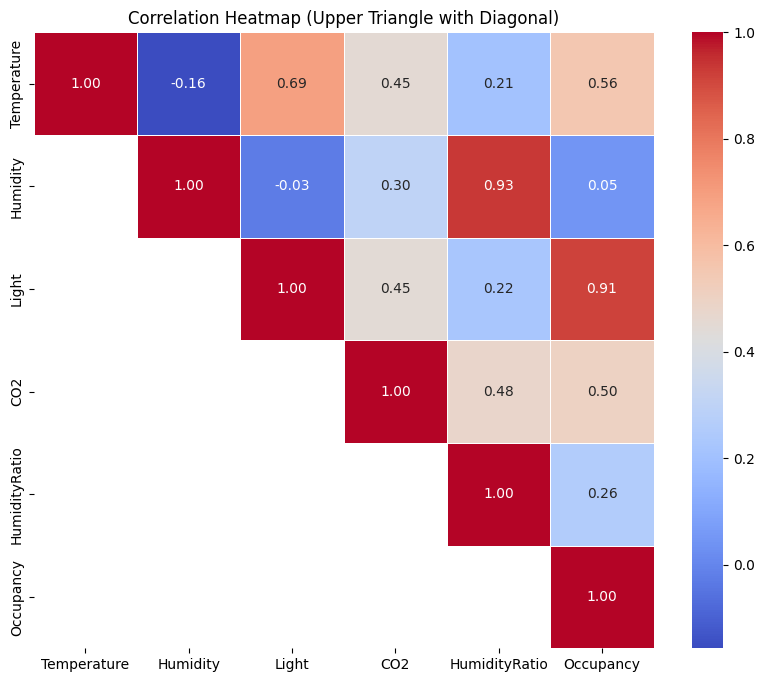

In [32]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
corr = numeric_df.corr()
mask = np.tril(np.ones_like(corr, dtype=bool), k=-1)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap (Upper Triangle with Diagonal)')
plt.show()

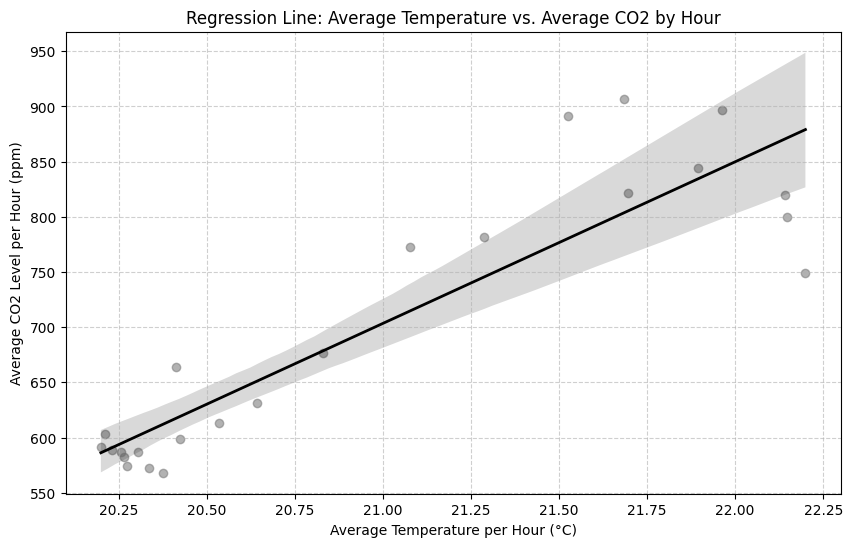

In [33]:

df['date'] = pd.to_datetime(df['date'])

df['hour'] = df['date'].dt.hour

hourly_avg_data = df.groupby('hour')[['Temperature', 'CO2']].mean().reset_index()

plt.figure(figsize=(10, 6))

sns.regplot(
    data=hourly_avg_data,
    x='Temperature',
    y='CO2',
    color='black',
    scatter_kws={'alpha':0.6, 'color':'gray'},
    line_kws={'color':'black', 'linewidth':2}
)

plt.title('Regression Line: Average Temperature vs. Average CO2 by Hour')
plt.xlabel('Average Temperature per Hour (°C)')
plt.ylabel('Average CO2 Level per Hour (ppm)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

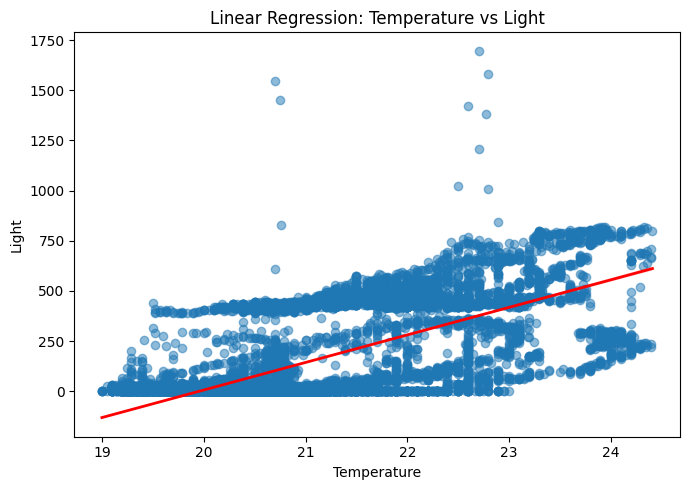

In [34]:
plt.figure(figsize=(7,5))
sns.regplot(x='Temperature', y='Light', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red', 'linewidth':2})
plt.title('Linear Regression: Temperature vs Light')
plt.xlabel('Temperature')
plt.ylabel('Light')
plt.tight_layout()
plt.show()

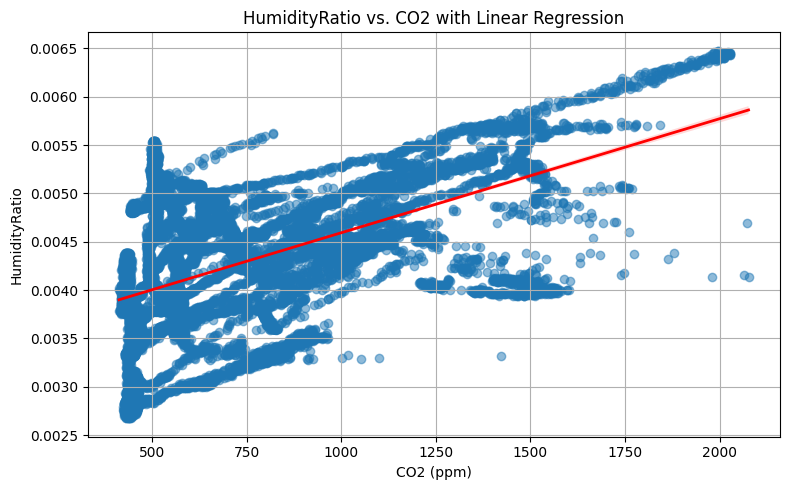

In [35]:
plt.figure(figsize=(8, 5))
sns.regplot(data=df, x='CO2', y='HumidityRatio', scatter_kws={'alpha':0.5}, line_kws={'color':'red', 'linewidth':2})
plt.title('HumidityRatio vs. CO2 with Linear Regression')
plt.xlabel('CO2 (ppm)')
plt.ylabel('HumidityRatio')
plt.grid(True)
plt.tight_layout()
plt.show()

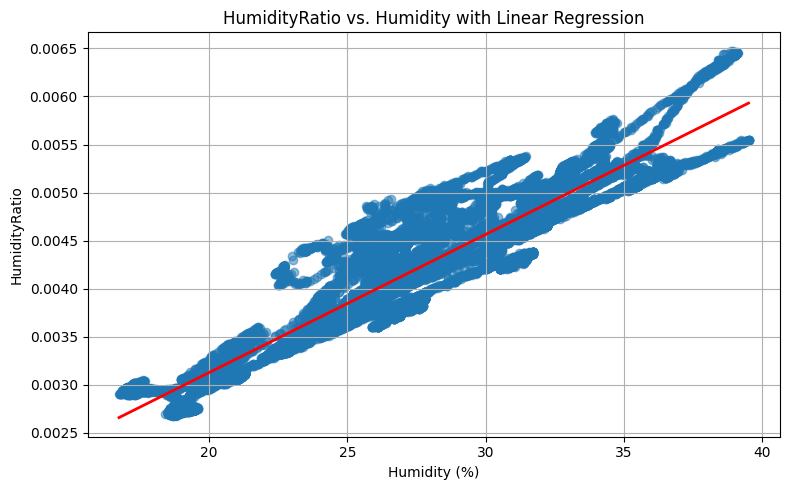

In [36]:
plt.figure(figsize=(8, 5))
sns.regplot(data=df, x='Humidity', y='HumidityRatio', scatter_kws={'alpha':0.5}, line_kws={'color':'red', 'linewidth':2})
plt.title('HumidityRatio vs. Humidity with Linear Regression')
plt.xlabel('Humidity (%)')
plt.ylabel('HumidityRatio')
plt.grid(True)
plt.tight_layout()
plt.show()

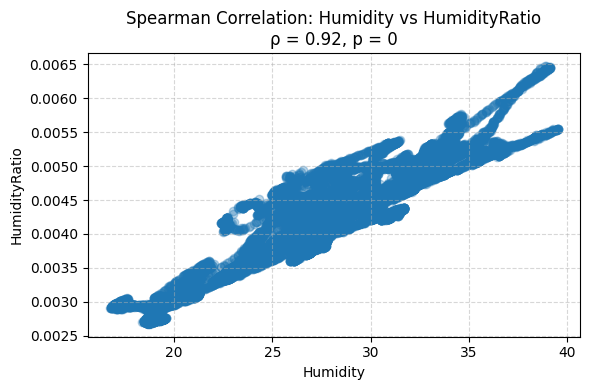

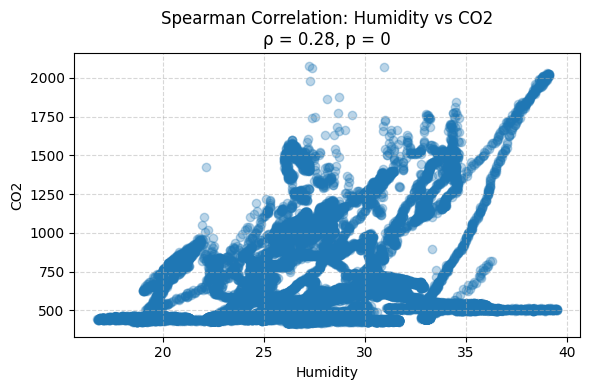

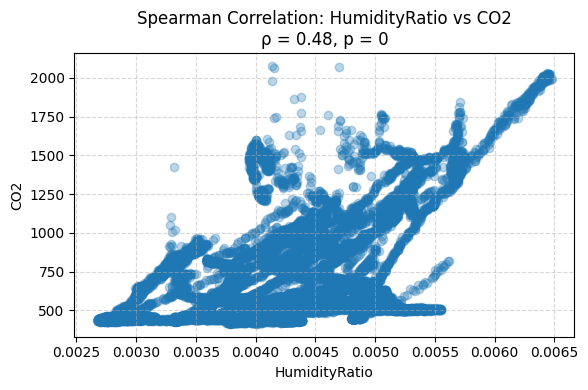

In [37]:
# Select olumns
numeric_cols = ['Humidity' , 'HumidityRatio', 'CO2']

# Generate scatterplots for all pairs of numeric features, excluding self-pairs and filtering by p-value
for col1, col2 in itertools.combinations(numeric_cols, 2):
    coef, p = spearmanr(df[col1], df[col2])
    if p < 0.01:  # Only plot highly significant correlations
        plt.figure(figsize=(6, 4))
        plt.scatter(df[col1], df[col2], alpha=0.3)
        plt.title(f"Spearman Correlation: {col1} vs {col2}\n"
                  f"ρ = {coef:.2f}, p = {p:.2g}")
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

### Analyze Relationships

In [38]:
# Calculate Spearman correlation matrix
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
spearman_corr = df[numeric_cols].corr(method='spearman')

# Filter pairs with correlation above 0.6
high_corr_pairs = []
for col1 in spearman_corr.columns:
    for col2 in spearman_corr.index:
        if col1 != col2 and spearman_corr.loc[col1, col2] > 0.6:
            high_corr_pairs.append((col1, col2, spearman_corr.loc[col1, col2]))

# Remove duplicates (e.g., (A, B) and (B, A))
unique_high_corr_pairs = []
seen = set()
for col1, col2, corr in high_corr_pairs:
    if (col2, col1) not in seen:
        unique_high_corr_pairs.append((col1, col2, corr))
        seen.add((col1, col2))

# Display results
print("Features with Spearman correlation > 0.6:")
for col1, col2, corr in unique_high_corr_pairs:
    print(f"{col1} vs {col2}: ρ = {corr:.2f}")

Features with Spearman correlation > 0.6:
Temperature vs Light: ρ = 0.63
Temperature vs CO2: ρ = 0.61
Humidity vs HumidityRatio: ρ = 0.92
Light vs Occupancy: ρ = 0.83


### Define Logical Combinations

Investigate relationships between correlated variables and define meaningful ranges or thresholds for combined variables.

In [39]:
# 1. Temperature vs Light
df['temp_bin'] = pd.cut(df['Temperature'], bins=[15,20,25])
df['light_bin'] = pd.cut(df['Light'], bins=[100,300,500,700])
grouped_temp_light = df.groupby(['temp_bin','light_bin'])['Occupancy'].mean().reset_index()
print("Temperature vs Light Occupancy Patterns:")
print(grouped_temp_light)

# 2. Temperature vs CO2
df['temp_bin'] = pd.cut(df['Temperature'], bins=[15,20,25])
df['co2_bin'] = pd.cut(df['CO2'], bins=[400,600,800,1000])
grouped_temp_co2 = df.groupby(['temp_bin','co2_bin'])['Occupancy'].mean().reset_index()
print("\nTemperature vs CO2 Occupancy Patterns:")
print(grouped_temp_co2)

# 3. Humidity vs HumidityRatio
df['humidity_bin'] = pd.cut(df['Humidity'], bins=[20,40])  
df['ratio_bin'] = pd.cut(df['HumidityRatio'], bins=[0.001,0.003,0.005,0.007])  
grouped_hum_ratio = df.groupby(['humidity_bin','ratio_bin'])['Occupancy'].mean().reset_index()
print("\nHumidity vs HumidityRatio Occupancy Patterns:")
print(grouped_hum_ratio)


Temperature vs Light Occupancy Patterns:
   temp_bin   light_bin  Occupancy
0  (15, 20]  (100, 300]   0.029412
1  (15, 20]  (300, 500]   0.862069
2  (15, 20]  (500, 700]        NaN
3  (20, 25]  (100, 300]   0.012516
4  (20, 25]  (300, 500]   0.916074
5  (20, 25]  (500, 700]   0.926413

Temperature vs CO2 Occupancy Patterns:
   temp_bin      co2_bin  Occupancy
0  (15, 20]   (400, 600]   0.004888
1  (15, 20]   (600, 800]   0.042254
2  (15, 20]  (800, 1000]        NaN
3  (20, 25]   (400, 600]   0.064683
4  (20, 25]   (600, 800]   0.255186
5  (20, 25]  (800, 1000]   0.648524

Humidity vs HumidityRatio Occupancy Patterns:
  humidity_bin       ratio_bin  Occupancy
0     (20, 40]  (0.001, 0.003]   0.000000
1     (20, 40]  (0.003, 0.005]   0.217793
2     (20, 40]  (0.005, 0.007]   0.380855


C:\Users\inbal\AppData\Local\Temp\ipykernel_45164\778794279.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\inbal\AppData\Local\Temp\ipykernel_45164\778794279.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\inbal\AppData\Local\Temp\ipykernel_45164\778794279.py:18: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



### Try Binnning Features Using pd.qcut()

In [40]:
import numpy as np
import pandas as pd

def grid_quality(df, f1, f2, q1, q2, target='Occupancy', min_n_flag=20):
    s = df[[f1, f2, target]].dropna().copy()
    s[f'{f1}_bin'] = pd.qcut(s[f1], q=q1, duplicates='drop')
    s[f'{f2}_bin'] = pd.qcut(s[f2], q=q2, duplicates='drop')

    out = (s.groupby([f'{f1}_bin', f'{f2}_bin'])[target]
             .agg(occ_rate='mean', n='size')
             .reset_index())

    # simple uncertainty proxy for a proportion
    out['se'] = np.sqrt(np.clip(out['occ_rate'] * (1 - out['occ_rate']) / out['n'], 0, None))
    # quick quality label (tweak thresholds if you want)
    out['quality'] = np.where(out['n'] < min_n_flag, 'low n',
                        np.where(out['se'] > 0.08, 'noisy', 'good'))
    return out.round({'occ_rate': 3, 'se': 3})

# 1) Temperature vs Light
print("Temperature vs Light Occupancy Patterns (with quality):")
print(grid_quality(df, 'Temperature', 'Light', q1=3, q2=3))

# 2) Temperature vs CO2
print("\nTemperature vs CO2 Occupancy Patterns (with quality):")
print(grid_quality(df, 'Temperature', 'CO2', q1=3, q2=3))

# 3) Humidity vs HumidityRatio
print("\nHumidity vs HumidityRatio Occupancy Patterns (with quality):")
print(grid_quality(df, 'Humidity', 'HumidityRatio', q1=2, q2=4))


Temperature vs Light Occupancy Patterns (with quality):
    Temperature_bin        Light_bin  occ_rate     n     se quality
0   (18.999, 20.39]   (-0.001, 31.0]     0.000  7176  0.000    good
1   (18.999, 20.39]  (31.0, 1697.25]     0.195   430  0.019    good
2   (20.39, 21.167]   (-0.001, 31.0]     0.000  5190  0.000    good
3   (20.39, 21.167]  (31.0, 1697.25]     0.615   917  0.016    good
4  (21.167, 24.408]   (-0.001, 31.0]     0.001  1422  0.001    good
5  (21.167, 24.408]  (31.0, 1697.25]     0.756  5425  0.006    good

Temperature vs CO2 Occupancy Patterns (with quality):
    Temperature_bin           CO2_bin  occ_rate     n     se quality
0   (18.999, 20.39]  (412.749, 499.5]     0.008  4265  0.001    good
1   (18.999, 20.39]    (499.5, 714.0]     0.012  2321  0.002    good
2   (18.999, 20.39]   (714.0, 2076.5]     0.022  1020  0.005    good
3   (20.39, 21.167]  (412.749, 499.5]     0.012  1959  0.002    good
4   (20.39, 21.167]    (499.5, 714.0]     0.097  2483  0.006    good

C:\Users\inbal\AppData\Local\Temp\ipykernel_45164\1152960740.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\inbal\AppData\Local\Temp\ipykernel_45164\1152960740.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\inbal\AppData\Local\Temp\ipykernel_45164\1152960740.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



### Define a combined logical feature

In [41]:
df['Comfort_Index'] = (
    (df['Temperature'].between(20,25)) &
    (df['Light'].between(300,700))
).astype(int)

df['Temp_CO2_Index'] = (
    (df['Temperature'].between(20,25)) &
    (df['CO2'].between(800,1000))
).astype(int)

df['Humidity_Index'] = (
    (df['Humidity'].between(20,40)) &
    (df['HumidityRatio'].between(0.005,0.007))
).astype(int)

### Random Forest with K‑Fold CV

In [42]:
X = df[['Temperature', 'Light', 'CO2', 'Humidity', 'HumidityRatio']]  # add or drop features as needed
y = df['Occupancy']  # target

In [43]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestRegressor(random_state=42)
cv_scores_rf = cross_val_score(rf, X, y, cv=kf, scoring='r2')


#### Feature Importance
##### See which predictors Random Forest thinks are most important:

In [44]:
rf.fit(X, y)
importances = rf.feature_importances_
for f, imp in zip(X.columns, importances):
    print(f"{f}: {imp:.3f}")

print("\n")
X_hum = df[['Humidity', 'HumidityRatio']]
rf.fit(X_hum, y)
for f, imp in zip(X_hum.columns, rf.feature_importances_):
    print(f, ":", round(imp, 4))
    

print("\n")
X_hum = df[['Humidity', 'CO2', 'Temperature']]
rf.fit(X_hum, y)
for f, imp in zip(X_hum.columns, rf.feature_importances_):
    print(f, ":", round(imp, 4))

Temperature: 0.012
Light: 0.955
CO2: 0.016
Humidity: 0.009
HumidityRatio: 0.009


Humidity : 0.462
HumidityRatio : 0.538


Humidity : 0.2013
CO2 : 0.2712
Temperature : 0.5275


#### We can drop one of the humidities since they are both contributing half.

### Test Random Forest with and without HumidityRatio

In [45]:
# Model with HumidityRatio
X_full = df[['Temperature', 'Light', 'CO2', 'Humidity', 'HumidityRatio']]
y = df['Occupancy']
cv_scores_full = cross_val_score(RandomForestRegressor(random_state=42), X_full, y, cv=5, scoring='r2')
print("Model with HumidityRatio - Avg CV R²:", np.mean(cv_scores_full))

# Model without HumidityRatio
X_reduced = df[['Temperature', 'Light', 'CO2', 'Humidity']]
cv_scores_reduced = cross_val_score(RandomForestRegressor(random_state=42), X_reduced, y, cv=5, scoring='r2')
print("Model without HumidityRatio - Avg CV R²:", np.mean(cv_scores_reduced))

Model with HumidityRatio - Avg CV R²: 0.8325523307755873
Model without HumidityRatio - Avg CV R²: 0.8382438426626916


### Drop HumidityRatio from the DataFrame

In [46]:
df = df.drop(columns=['HumidityRatio'])

### Conclusion:
#### - Random Forest handled correlated features well, showing no signs of overfitting or performance loss.
#### - Logical, interpretable features like Comfort_Index preserved high predictive accuracy (R² ≈ 0.82), and combining it with Light and Humidity nearly matched full-model performance (R² ≈ 0.956).

#### Train and test random splits

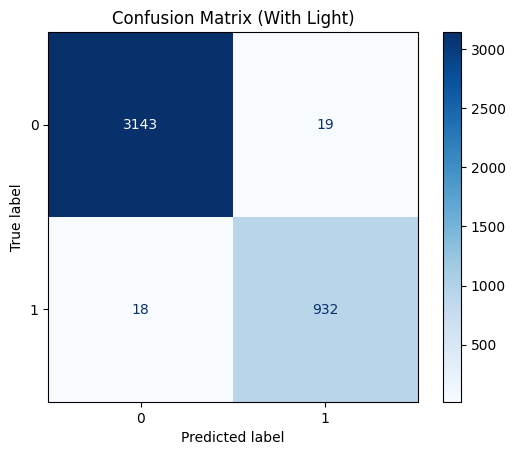

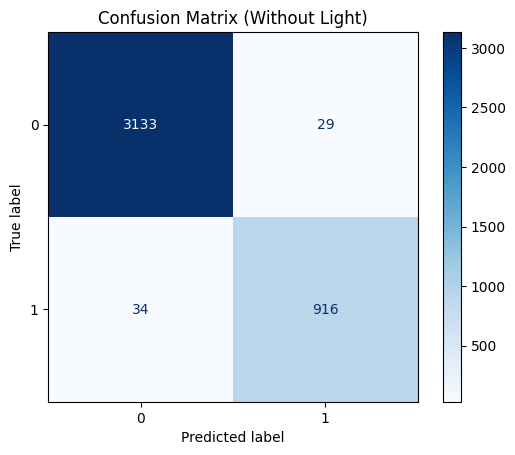

WITH LIGHT feature:
 precision       0.992249
recall          0.992218
f1-score        0.992228
support      4112.000000
dtype: float64

WITHOUT LIGHT feature:
 precision       0.984170
recall          0.984193
f1-score        0.984172
support      4112.000000
dtype: float64


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Helper function ---
def evaluate_random_splits(df, features, target='Occupancy', n_runs=5, test_size=0.2, random_state=None, plot_cm=False, label=""):
    metrics_list = []
    last_cm = None
    last_model = None
    last_y_test, last_y_pred = None, None

    for i in range(n_runs):
        X_train, X_test, y_train, y_test = train_test_split(
            df[features], df[target], 
            test_size=test_size, 
            random_state=(random_state+i if random_state else None),
            stratify=df[target]
        )

        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        metrics_list.append(report['weighted avg'])  # store precision/recall/F1

        # keep last split for confusion matrix
        last_model = model
        last_cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
        last_y_test, last_y_pred = y_test, y_pred

    if plot_cm and last_cm is not None:
        disp = ConfusionMatrixDisplay(confusion_matrix=last_cm, display_labels=last_model.classes_)
        disp.plot(cmap=plt.cm.Blues, values_format='d')
        plt.title(f"Confusion Matrix ({label})")
        plt.show()

    return pd.DataFrame(metrics_list)

# --- Features sets ---
features_with_light = ['Temperature', 'Humidity', 'CO2', 'Light']  # With Light
features_without_light = ['Temperature', 'Humidity', 'CO2']        # Without Light

# --- Run evaluation ---
results_with_light = evaluate_random_splits(df, features_with_light, n_runs=5, plot_cm=True, label="With Light")
results_without_light = evaluate_random_splits(df, features_without_light, n_runs=5, plot_cm=True, label="Without Light")

print("WITH LIGHT feature:\n", results_with_light.mean())
print("\nWITHOUT LIGHT feature:\n", results_without_light.mean())


### Training with time-based splits - Didn't help

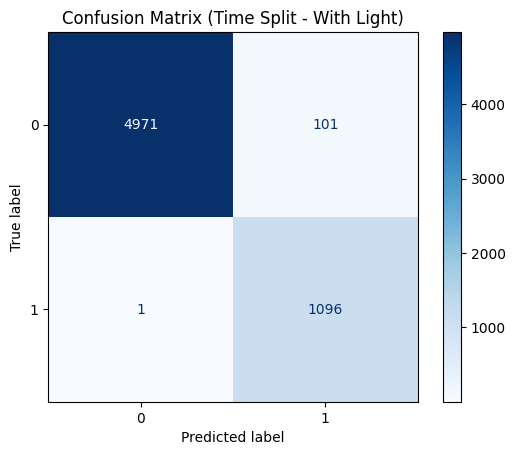

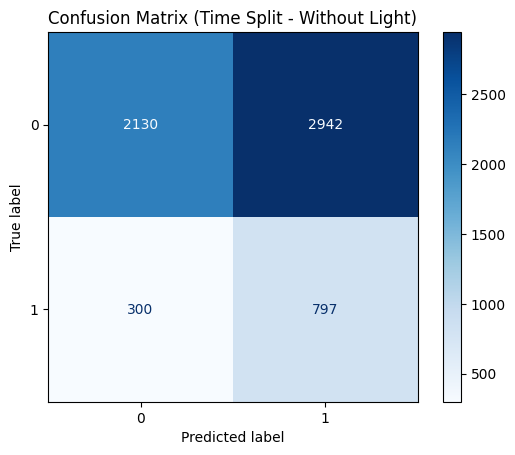

TIME-BASED SPLIT (WITH LIGHT):
    precision    recall  f1-score  support
0    0.98483  0.983466  0.983744   6169.0

TIME-BASED SPLIT (WITHOUT LIGHT):
    precision    recall  f1-score  support
0   0.758577  0.474469  0.525484   6169.0


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Time-based split evaluation ---
def evaluate_time_split(df, features, target='Occupancy', train_size=0.7, plot_cm=False, label=""):
    """
    Splits dataset chronologically: first train_size% for training, remainder for testing.
    Assumes df has a datetime index or a timestamp column.
    """
    # If timestamp column exists, sort by it; otherwise just use index order
    if "date" in df.columns or "timestamp" in df.columns:
        sort_col = "date" if "date" in df.columns else "timestamp"
        df_sorted = df.sort_values(by=sort_col)
    else:
        df_sorted = df.sort_index()

    n_train = int(len(df_sorted) * train_size)

    train = df_sorted.iloc[:n_train]
    test  = df_sorted.iloc[n_train:]

    X_train, y_train = train[features], train[target]
    X_test, y_test   = test[features], test[target]

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    # optional: plot confusion matrix
    if plot_cm:
        cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        disp.plot(cmap=plt.cm.Blues, values_format='d')
        plt.title(f"Confusion Matrix (Time Split - {label})")
        plt.show()

    return pd.DataFrame([report['weighted avg']])

# --- Feature sets ---
features_with_light = ['Temperature', 'Humidity', 'CO2', 'Light']
features_without_light = ['Temperature', 'Humidity', 'CO2']

# --- Run time-based evaluation ---
results_time_with_light = evaluate_time_split(df, features_with_light, plot_cm=True, label="With Light")
results_time_without_light = evaluate_time_split(df, features_without_light, plot_cm=True, label="Without Light")

print("TIME-BASED SPLIT (WITH LIGHT):\n", results_time_with_light)
print("\nTIME-BASED SPLIT (WITHOUT LIGHT):\n", results_time_without_light)


### Trying without Light or CO2 - Didn't help also

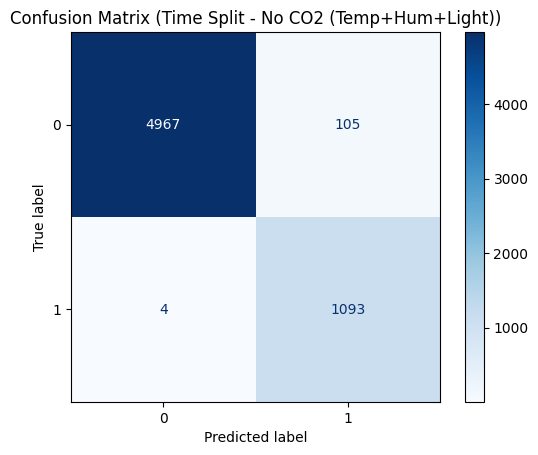

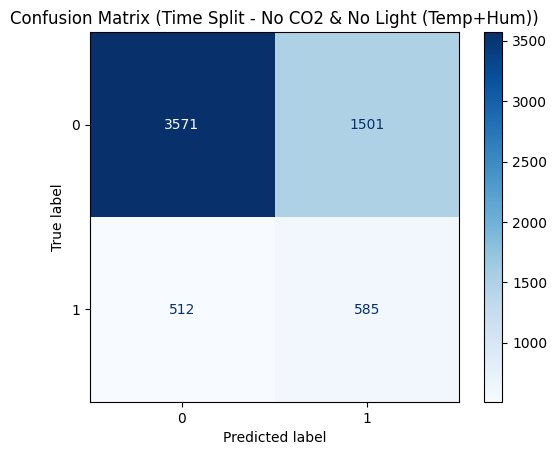

   precision    recall  f1-score  support                         model
0   0.984830  0.983466  0.983744   6169.0                   All + Light
0   0.758577  0.474469  0.525484   6169.0                      No Light
0   0.983753  0.982331  0.982631   6169.0       No CO2 (Temp+Hum+Light)
0   0.768946  0.673691  0.706760   6169.0  No CO2 & No Light (Temp+Hum)


C:\Users\inbal\AppData\Local\Temp\ipykernel_45164\2858989278.py:29: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\inbal\AppData\Local\Temp\ipykernel_45164\2858989278.py:29: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\inbal\AppData\Local\Temp\ipykernel_45164\2858989278.py:29: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



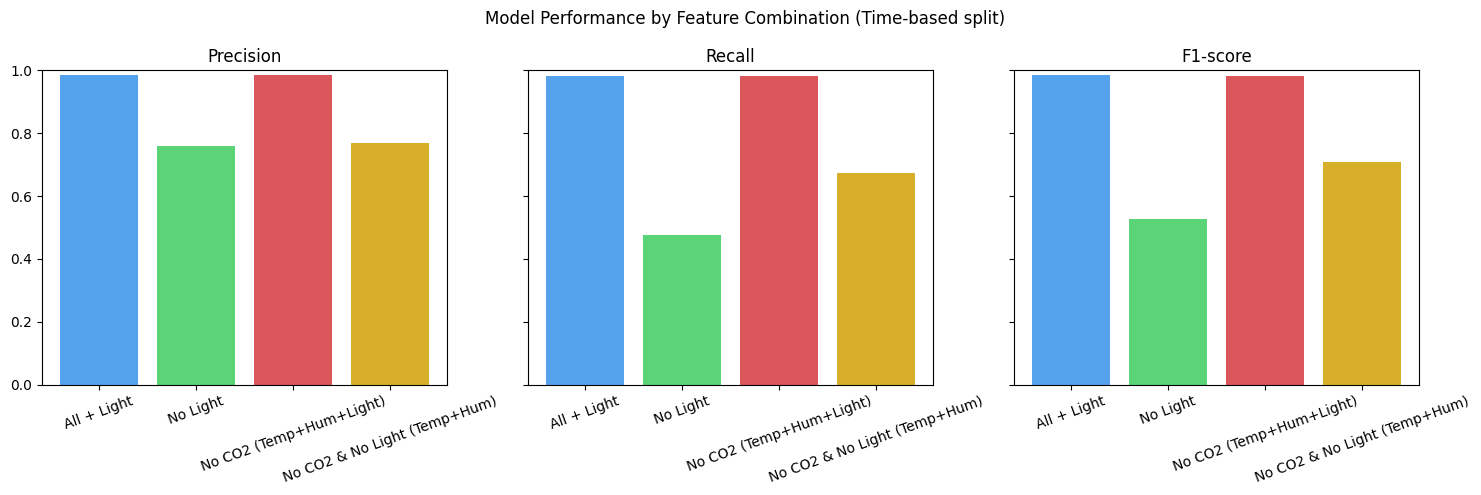

In [49]:
# --- Feature subsets ---
features_no_co2 = ['Temperature', 'Humidity', 'Light']        # without CO2
features_no_co2_light = ['Temperature', 'Humidity']           # without CO2 and Light

# --- Evaluate with confusion matrices ---
res_no_co2 = evaluate_time_split(df, features_no_co2, plot_cm=True, label="No CO2 (Temp+Hum+Light)")
res_no_co2_light = evaluate_time_split(df, features_no_co2_light, plot_cm=True, label="No CO2 & No Light (Temp+Hum)")

# Collect results into one DataFrame
results_compare = pd.concat([
    results_time_with_light.assign(model="All + Light"),
    results_time_without_light.assign(model="No Light"),
    res_no_co2.assign(model="No CO2 (Temp+Hum+Light)"),
    res_no_co2_light.assign(model="No CO2 & No Light (Temp+Hum)")
])

print(results_compare)

# --- Plot results ---
metrics = ["precision", "recall", "f1-score"]

fig, axes = plt.subplots(1, 3, figsize=(15,5), sharey=True)
colors = ["#54A2EC","#5AD476","#DA565B","#D8AF28"]

for i, metric in enumerate(metrics):
    axes[i].bar(results_compare["model"], results_compare[metric], color=colors)
    axes[i].set_title(metric.capitalize())
    axes[i].set_ylim(0,1)
    axes[i].set_xticklabels(results_compare["model"], rotation=20)

plt.suptitle("Model Performance by Feature Combination (Time-based split)")
plt.tight_layout()
plt.show()


### Let's add Time as a feature:

In [50]:
# 1) Add time features to df
import numpy as np
import pandas as pd

# Ensure datetime column exists and is parsed
time_col = 'date' if 'date' in df.columns else ('timestamp' if 'timestamp' in df.columns else None)
assert time_col is not None, "No 'date' or 'timestamp' column found in df."

df[time_col] = pd.to_datetime(df[time_col])

# Minutes since midnight (e.g., 03:04 -> 184)
df['minutes'] = df[time_col].dt.hour * 60 + df[time_col].dt.minute

# Cyclic encoding (recommended)
df['minutes_sin'] = np.sin(2 * np.pi * df['minutes'] / 1440.0)
df['minutes_cos'] = np.cos(2 * np.pi * df['minutes'] / 1440.0)


### Train with time-based split: The best result so far

In [51]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate_time_split(df, features, target='Occupancy', train_size=0.7, plot_cm=False, label=""):
    # sort chronologically
    sort_col = time_col
    df_sorted = df.sort_values(sort_col)

    n_train = int(len(df_sorted) * train_size)
    train, test = df_sorted.iloc[:n_train], df_sorted.iloc[n_train:]

    X_train, y_train = train[features], train[target]
    X_test,  y_test  = test[features],  test[target]

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)['weighted avg']

    if plot_cm:
        cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
        ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot(cmap=plt.cm.Blues, values_format='d')
        plt.title(f"Confusion Matrix (Time Split — {label})")
        plt.show()

    # return a 1-row DataFrame
    return pd.DataFrame([report])


### Define feature sets (add minutes_sin/cos) and train

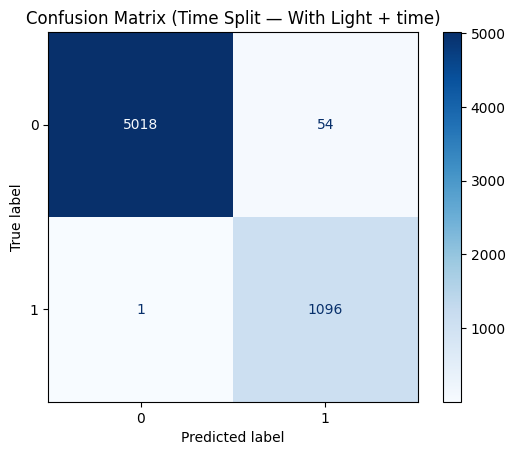

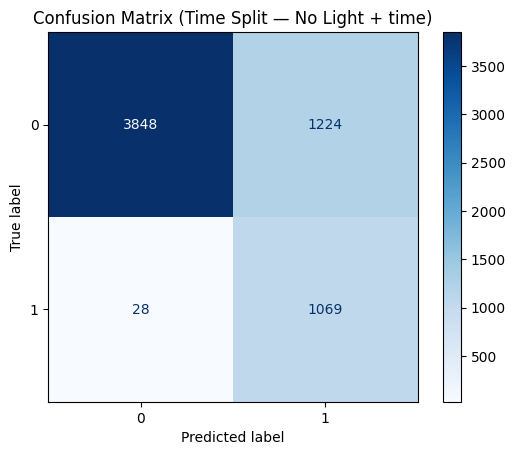

TIME-BASED (WITH LIGHT + time):
    precision    recall  f1-score  support
0   0.991486  0.991084  0.991166   6169.0

TIME-BASED (NO LIGHT + time):
    precision   recall  f1-score  support
0   0.899138  0.79705  0.819287   6169.0


In [52]:
features_with_light_time    = ['Temperature', 'Humidity', 'CO2', 'Light', 'minutes_sin', 'minutes_cos']
features_without_light_time = ['Temperature', 'Humidity', 'CO2', 'minutes_sin', 'minutes_cos']

res_with_light_time = evaluate_time_split(df, features_with_light_time,  plot_cm=True, label="With Light + time")
res_no_light_time   = evaluate_time_split(df, features_without_light_time, plot_cm=True, label="No Light + time")

print("TIME-BASED (WITH LIGHT + time):\n", res_with_light_time)
print("\nTIME-BASED (NO LIGHT + time):\n",   res_no_light_time)


### Decision Trees - Worse

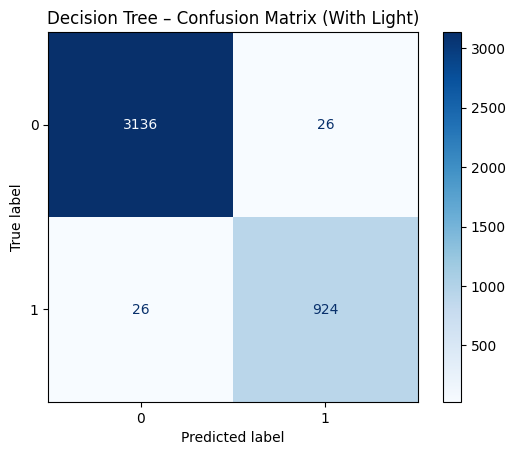

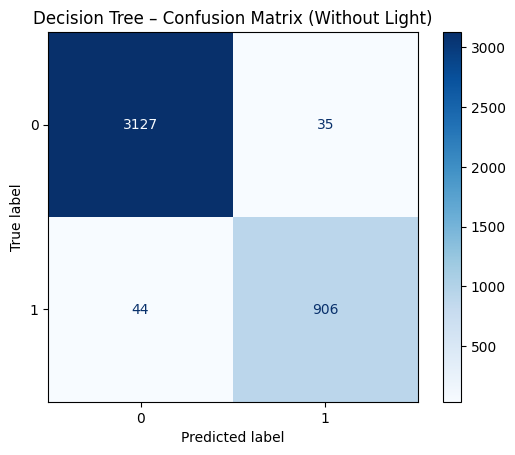

DECISION TREE – WITH LIGHT:
 precision       0.990172
recall          0.990175
f1-score        0.990168
support      4112.000000
dtype: float64

DECISION TREE – WITHOUT LIGHT:
 precision       0.978142
recall          0.978113
f1-score        0.978122
support      4112.000000
dtype: float64


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# ---------- Optional: add robust time features if a datetime column exists ----------
def add_time_features_if_any(df, dt_cols=("Timestamp","DateTime","datetime","time","Time")):
    df = df.copy()
    found = [c for c in dt_cols if c in df.columns]
    for c in found:
        # ensure dtype is datetime
        if not np.issubdtype(df[c].dtype, np.datetime64):
            df[c] = pd.to_datetime(df[c], errors="coerce")
        # build compact + cyclical time features
        hour   = df[c].dt.hour
        minute = df[c].dt.minute
        dow    = df[c].dt.dayofweek  # 0=Mon..6=Sun
        minute_of_day = hour*60 + minute

        df[f"{c}_minute_of_day"] = minute_of_day
        df[f"{c}_sin_day"] = np.sin(2*np.pi*minute_of_day/1440)
        df[f"{c}_cos_day"] = np.cos(2*np.pi*minute_of_day/1440)
        df[f"{c}_dow"]     = dow

        # drop original datetime column
        df.drop(columns=[c], inplace=True)
    return df

# Call this once on your df (safe even if no datetime cols are present)
df = add_time_features_if_any(df)

# ---------- Decision Tree evaluator (mirrors your RF function) ----------
def evaluate_decision_tree(
    df, features, target='Occupancy', n_runs=5, test_size=0.2,
    random_state=None, plot_cm=False, label="", dt_kwargs=None
):
    if dt_kwargs is None:
        dt_kwargs = dict(
            criterion="gini",
            max_depth=None,          # try small values (e.g., 5, 8, 12) to reduce overfitting
            min_samples_split=2,
            min_samples_leaf=1,
            random_state=42
        )

    metrics_list = []
    last_cm = None
    last_model = None
    last_y_test, last_y_pred = None, None

    for i in range(n_runs):
        X_train, X_test, y_train, y_test = train_test_split(
            df[features], df[target],
            test_size=test_size,
            random_state=(random_state+i if random_state else None),
            stratify=df[target]
        )

        model = DecisionTreeClassifier(**dt_kwargs)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        metrics_list.append(report['weighted avg'])

        last_model = model
        last_cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
        last_y_test, last_y_pred = y_test, y_pred

    if plot_cm and last_cm is not None:
        disp = ConfusionMatrixDisplay(confusion_matrix=last_cm, display_labels=last_model.classes_)
        disp.plot(cmap=plt.cm.Blues, values_format='d')
        plt.title(f"Decision Tree – Confusion Matrix ({label})")
        plt.show()

    return pd.DataFrame(metrics_list), last_model

# ---------- Feature sets (same as your RF) ----------
features_with_light    = ['Temperature', 'Humidity', 'CO2', 'Light']
features_without_light = ['Temperature', 'Humidity', 'CO2']

# ---------- Run evaluation (default, unconstrained tree) ----------
dt_results_with_light, dt_model_with_light = evaluate_decision_tree(
    df, features_with_light, n_runs=5, plot_cm=True, label="With Light"
)
dt_results_without_light, dt_model_without_light = evaluate_decision_tree(
    df, features_without_light, n_runs=5, plot_cm=True, label="Without Light"
)

print("DECISION TREE – WITH LIGHT:\n", dt_results_with_light.mean())
print("\nDECISION TREE – WITHOUT LIGHT:\n", dt_results_without_light.mean())



### Adding TimeSeriesSplit

In [ ]:
df_raw = df.copy()  

# Try to discover the timestamp column and standardize its name
time_col_candidates = ['Timestamp', 'Time', 'DateTime', 'datetime', 'date', 'ts']
time_col = next((c for c in time_col_candidates if c in df_raw.columns), None)

if time_col is not None:
    df_raw[time_col] = pd.to_datetime(df_raw[time_col], errors='coerce')
    df_ts = df_raw.sort_values(time_col).reset_index(drop=True)
else:
    # If no explicit time column, assume current order is chronological
    df_ts = df_raw.reset_index(drop=True)

# Ensure required columns exist
required_cols = set(['Temperature','Humidity','CO2','Occupancy']) | set(['Light'])  # Light used in one setting
missing = [c for c in required_cols if c not in df_ts.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Optional: drop rows with any NA in the features/target
use_cols = ['Temperature','Humidity','CO2','Light','Occupancy']
use_cols = [c for c in use_cols if c in df_ts.columns]  # guard if Light missing for the 'no Light' run
df_ts = df_ts.dropna(subset=use_cols).reset_index(drop=True)


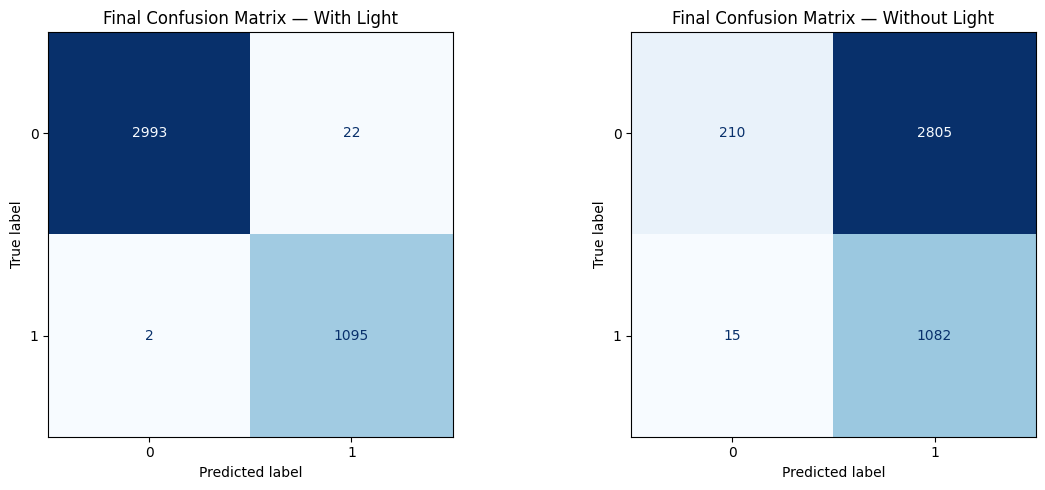


=== Chronological Final Evaluation (80/20) ===


,Precision (weighted),Recall (weighted),F1 (weighted),Support
Setting,,,,
With Light,0.994,0.994,0.994,4112
Without Light,0.759,0.314,0.211,4112


In [61]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- CONFIG ---
FEATURES_WITH  = ['Temperature','Humidity','CO2','Light']
FEATURES_NO    = ['Temperature','Humidity','CO2']
DT_KWARGS      = dict(max_depth=5, min_samples_split=50, random_state=42)
TEST_SIZE      = 0.2  # last 20% is test

# --- Chronological split helper ---
def chrono_split(df_ts, features, target='Occupancy', test_size=TEST_SIZE):
    n = len(df_ts)
    split_idx = int((1 - test_size) * n)
    X_train = df_ts[features].iloc[:split_idx]
    y_train = df_ts[target].iloc[:split_idx]
    X_test  = df_ts[features].iloc[split_idx:]
    y_test  = df_ts[target].iloc[split_idx:]
    return X_train, X_test, y_train, y_test

def train_eval_confmat(df_ts, features, title):
    X_train, X_test, y_train, y_test = chrono_split(df_ts, features)
    model = DecisionTreeClassifier(**DT_KWARGS)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # metrics
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    metrics = {
        "Setting": title,
        "Precision (weighted)": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall (weighted)"   : recall_score(y_test, y_pred, average='weighted', zero_division=0),
        "F1 (weighted)"       : f1_score(y_test, y_pred, average='weighted', zero_division=0),
        "Support"             : len(y_test)
    }

    # confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=np.sort(model.classes_))
    return model, metrics, cm, np.sort(model.classes_)

# --- Run both settings ---
model_with,  metrics_with,  cm_with,  classes_with  = train_eval_confmat(df_ts, FEATURES_WITH, "With Light")
model_no,    metrics_no,    cm_no,    classes_no    = train_eval_confmat(df_ts, FEATURES_NO,   "Without Light")

# --- Show side-by-side confusion matrices ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_with, display_labels=classes_with)
disp1.plot(cmap=plt.cm.Blues, values_format='d', ax=axes[0], colorbar=False)
axes[0].set_title("Final Confusion Matrix — With Light")

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_no, display_labels=classes_no)
disp2.plot(cmap=plt.cm.Blues, values_format='d', ax=axes[1], colorbar=False)
axes[1].set_title("Final Confusion Matrix — Without Light")

plt.tight_layout()
plt.show()

# --- Comparison table ---
summary_df = pd.DataFrame([metrics_with, metrics_no]).set_index("Setting")
print("\n=== Chronological Final Evaluation (80/20) ===")
display(summary_df.round(3))


### Random forest vs. Decision tree = the same results


=== FINAL CONFUSION MATRIX (Aggregated over 5 folds, No Light) ===
              precision    recall  f1-score   support

           0       0.87      0.68      0.76     13368
           1       0.36      0.65      0.46      3762

    accuracy                           0.67     17130
   macro avg       0.62      0.66      0.61     17130
weighted avg       0.76      0.67      0.70     17130



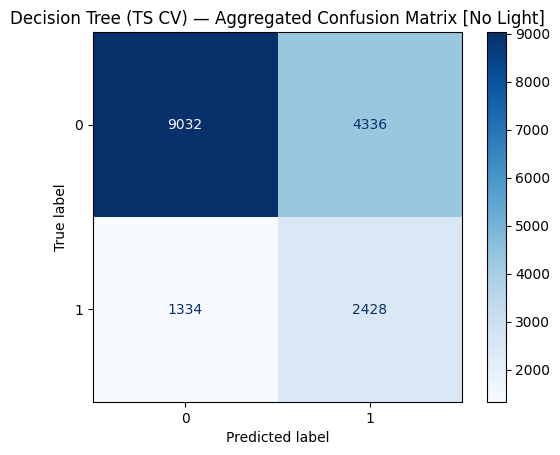


Per-fold summary (no light):
   fold  f1_weighted
0     1     0.899790
1     2     0.764087
2     3     0.677309
3     4     0.426827
4     5     0.665814

=== Head-to-head (F1, mean ± std) ===
With Light    : 0.992 ± 0.001
Without Light : 0.687 ± 0.173


In [ ]:
# ---- Evaluate WITHOUT LIGHT ----
features_without_light = ['Temperature', 'Humidity', 'CO2']

X_noL = df[features_without_light].to_numpy()
y_noL = df['Occupancy'].to_numpy()

dt_noL = DecisionTreeClassifier(max_depth=5, min_samples_split=50, random_state=42)

# --- Collect predictions across all 5 folds ---
y_true_all, y_pred_all = [], []
fold_reports_noL = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X_noL), start=1):
    Xtr, Xte = X_noL[train_idx], X_noL[test_idx]
    ytr, yte = y_noL[train_idx], y_noL[test_idx]

    model = DecisionTreeClassifier(max_depth=5, min_samples_split=50, random_state=42)
    model.fit(Xtr, ytr)
    yhat = model.predict(Xte)

    # extend global lists
    y_true_all.extend(yte)
    y_pred_all.extend(yhat)

    # optional: per-fold report
    f1 = f1_score(yte, yhat, average='weighted', zero_division=0)
    fold_reports_noL.append({'fold': fold, 'f1_weighted': f1})

# --- Final aggregated confusion matrix ---
cm_final = confusion_matrix(y_true_all, y_pred_all)
print("\n=== FINAL CONFUSION MATRIX (Aggregated over 5 folds, No Light) ===")
print(classification_report(y_true_all, y_pred_all, zero_division=0))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_final)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Decision Tree (TS CV) — Aggregated Confusion Matrix [No Light]")
plt.show()


fold_df_noL = pd.DataFrame(fold_reports_noL)
print("\nPer-fold summary (no light):")
print(fold_df_noL)

# ---- Quick head-to-head summary ----
# Use dt_results_with_light for "with light" per-fold results
fold_df = dt_results_with_light.copy()
fold_df['fold'] = range(1, len(fold_df) + 1)
fold_df['f1_weighted'] = fold_df['f1-score']

print("\n=== Head-to-head (F1, mean ± std) ===")
print(f"With Light    : {fold_df['f1_weighted'].mean():.3f} ± {fold_df['f1_weighted'].std():.3f}")
print(f"Without Light : {fold_df_noL['f1_weighted'].mean():.3f} ± {fold_df_noL['f1_weighted'].std():.3f}")
